In [14]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [15]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [16]:
# get data
try:
    df = pd.read_csv("../data/AirPassengers.csv", parse_dates=["Month"])
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("AirPassengers.csv"), parse_dates=["Month"])

df.shape

(144, 2)

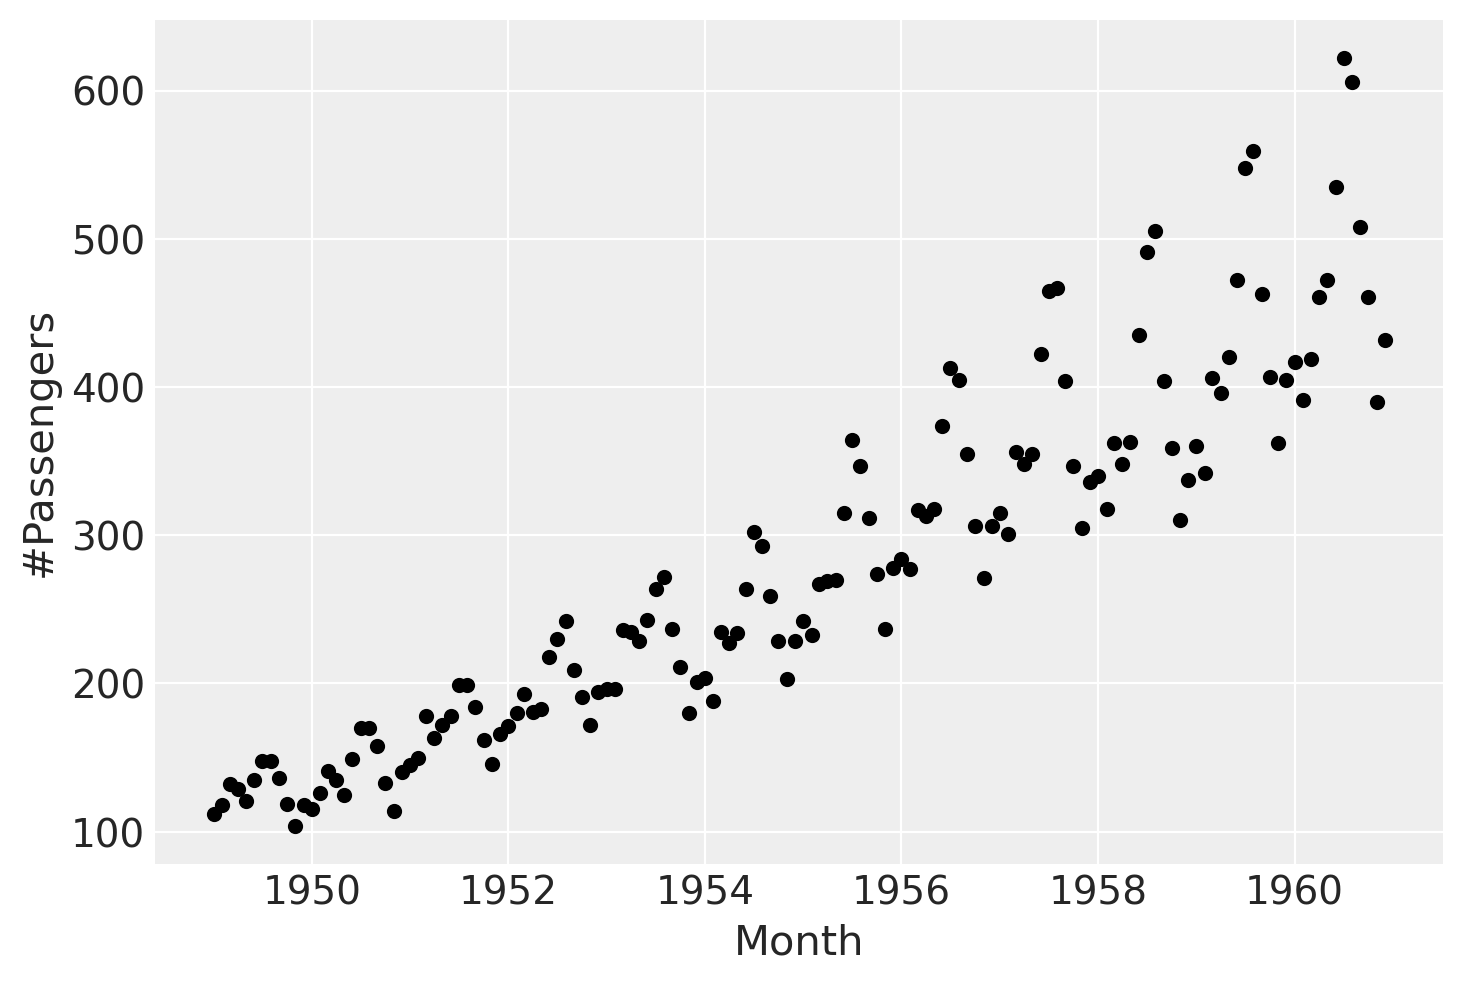

In [17]:
df.plot.scatter(x="Month", y="#Passengers", color="k");

### Scale

In [18]:
t = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [19]:
y = df["#Passengers"].to_numpy()
y_max = np.max(y)
y = y / y_max

#### Linear trend

$
Passengers = \alpha + \Beta t
$

Sampling: [likelihood, α, β, σ]
/tmp/ipykernel_31239/2081846948.py:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_31239/2081846948.py:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


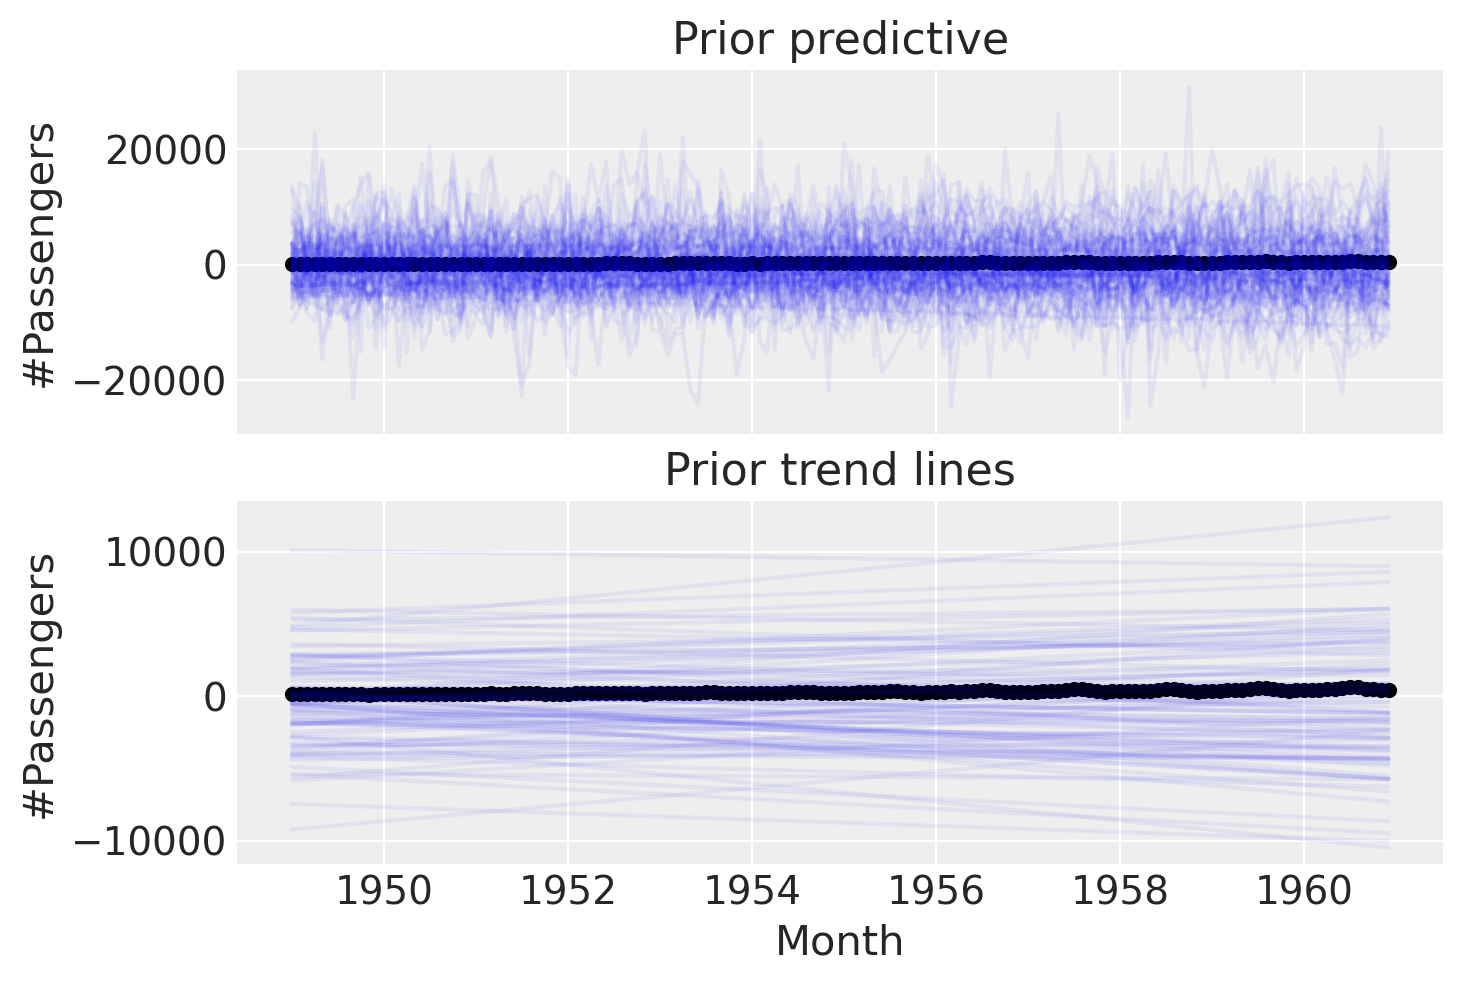

In [20]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");



##### Much to wide, retry

Sampling: [likelihood, α, β, σ]
/tmp/ipykernel_31239/2087553596.py:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_31239/2087553596.py:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


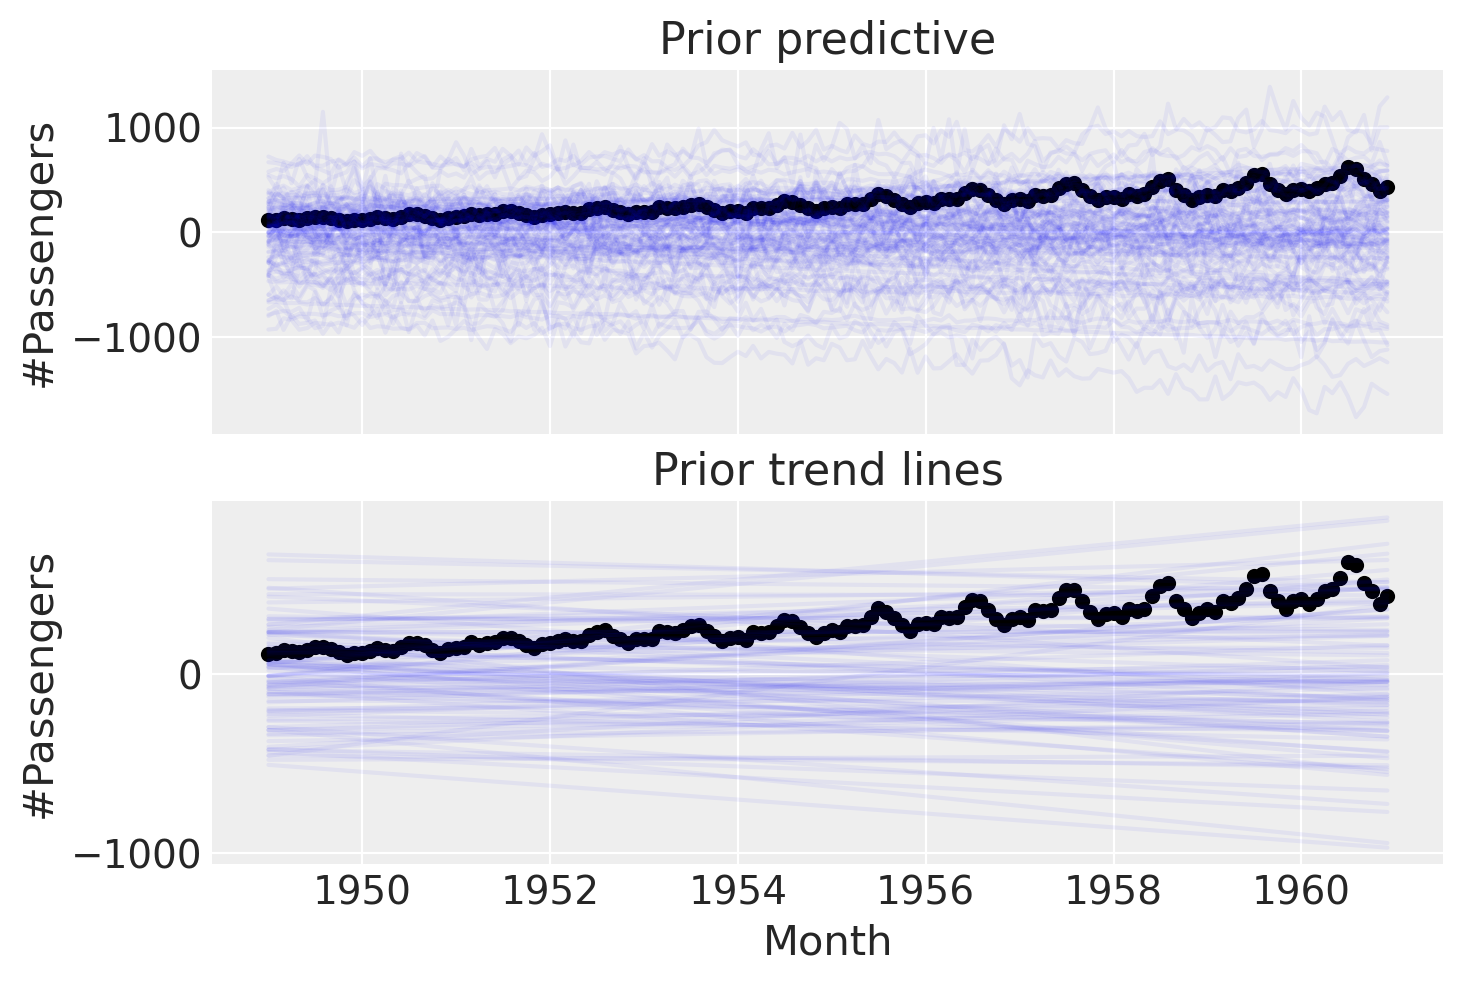

In [21]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=.5)
    β = pm.Normal("β", mu=0, sigma=.5)
    σ = pm.HalfNormal("σ", sigma=.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [likelihood]


Output()

/tmp/ipykernel_31239/1906849811.py:8: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
/tmp/ipykernel_31239/1906849811.py:17: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,


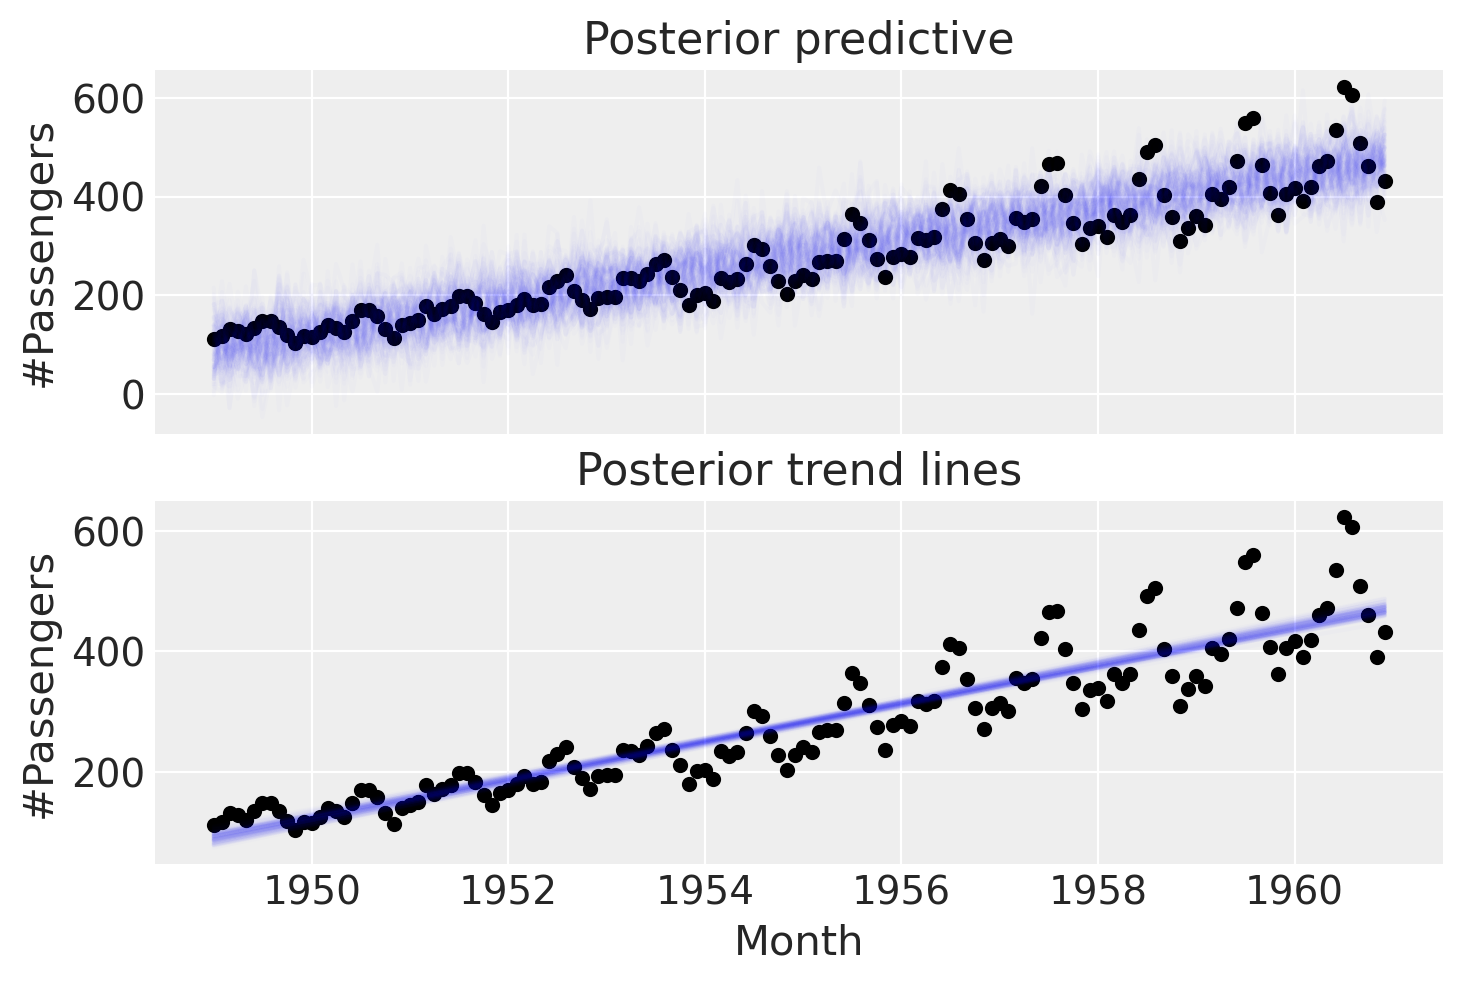

In [22]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

### Seasonality

In [23]:

n_order = 5
periods = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days / 365.25

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5
0,-0.004301,0.999991,-0.008601,0.999963,-0.012901,0.999917,-0.017202,0.999852,-0.021501,0.999769
1,0.504648,0.863325,0.871351,0.490660,0.999870,-0.016127,0.855075,-0.518505,0.476544,-0.879150
2,0.847173,0.531317,0.900235,-0.435405,0.109446,-0.993993,-0.783934,-0.620844,-0.942480,0.334263
3,0.999639,0.026876,0.053732,-0.998555,-0.996751,-0.080549,-0.107308,0.994226,0.990983,0.133990
4,0.882712,-0.469915,-0.829598,-0.558361,-0.103031,0.994678,0.926430,-0.376467,-0.767655,-0.640864
...,...,...,...,...,...,...,...,...,...,...
139,-0.484089,-0.875019,0.847173,0.531317,-0.998497,-0.054805,0.900235,-0.435405,-0.576948,0.816781
140,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667,-0.848314,-0.529494,0.886721,-0.462305
141,-0.999870,-0.016127,0.032249,-0.999480,0.998830,0.048363,-0.064464,0.997920,-0.996751,-0.080549
142,-0.869233,0.494403,-0.859503,-0.511131,0.019352,-0.999813,0.878637,-0.477489,0.849450,0.527668


Sampling: [likelihood, α, β, β_fourier, σ]
/tmp/ipykernel_31239/2112104758.py:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
/tmp/ipykernel_31239/2112104758.py:30: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_31239/2112104758.py:38: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:12]


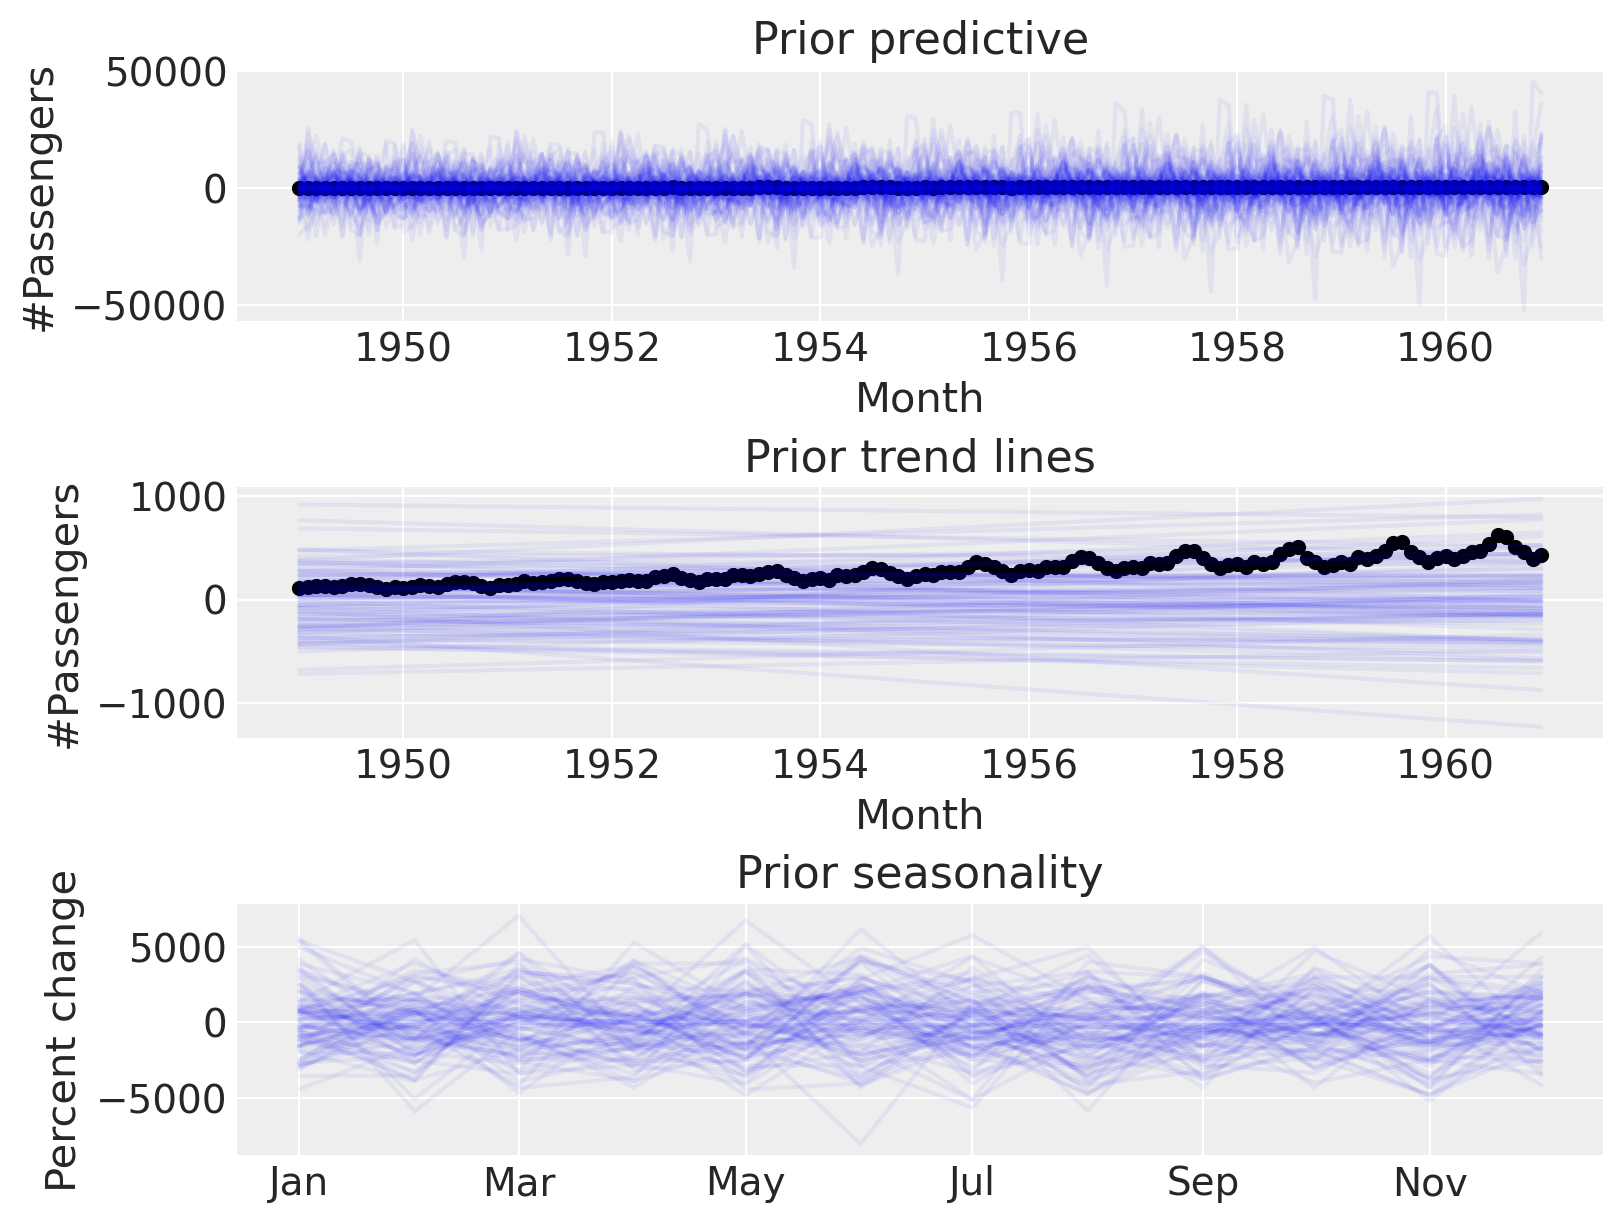

In [24]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    β_fourier = pm.Normal("β_fourier", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", α + β * t)
    μ = trend * (1 + seasonality)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_seasonality_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:12]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Sampling: [likelihood, α, β, β_fourier, σ]
/tmp/ipykernel_31239/4148154925.py:21: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
/tmp/ipykernel_31239/4148154925.py:32: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_31239/4148154925.py:40: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:12]


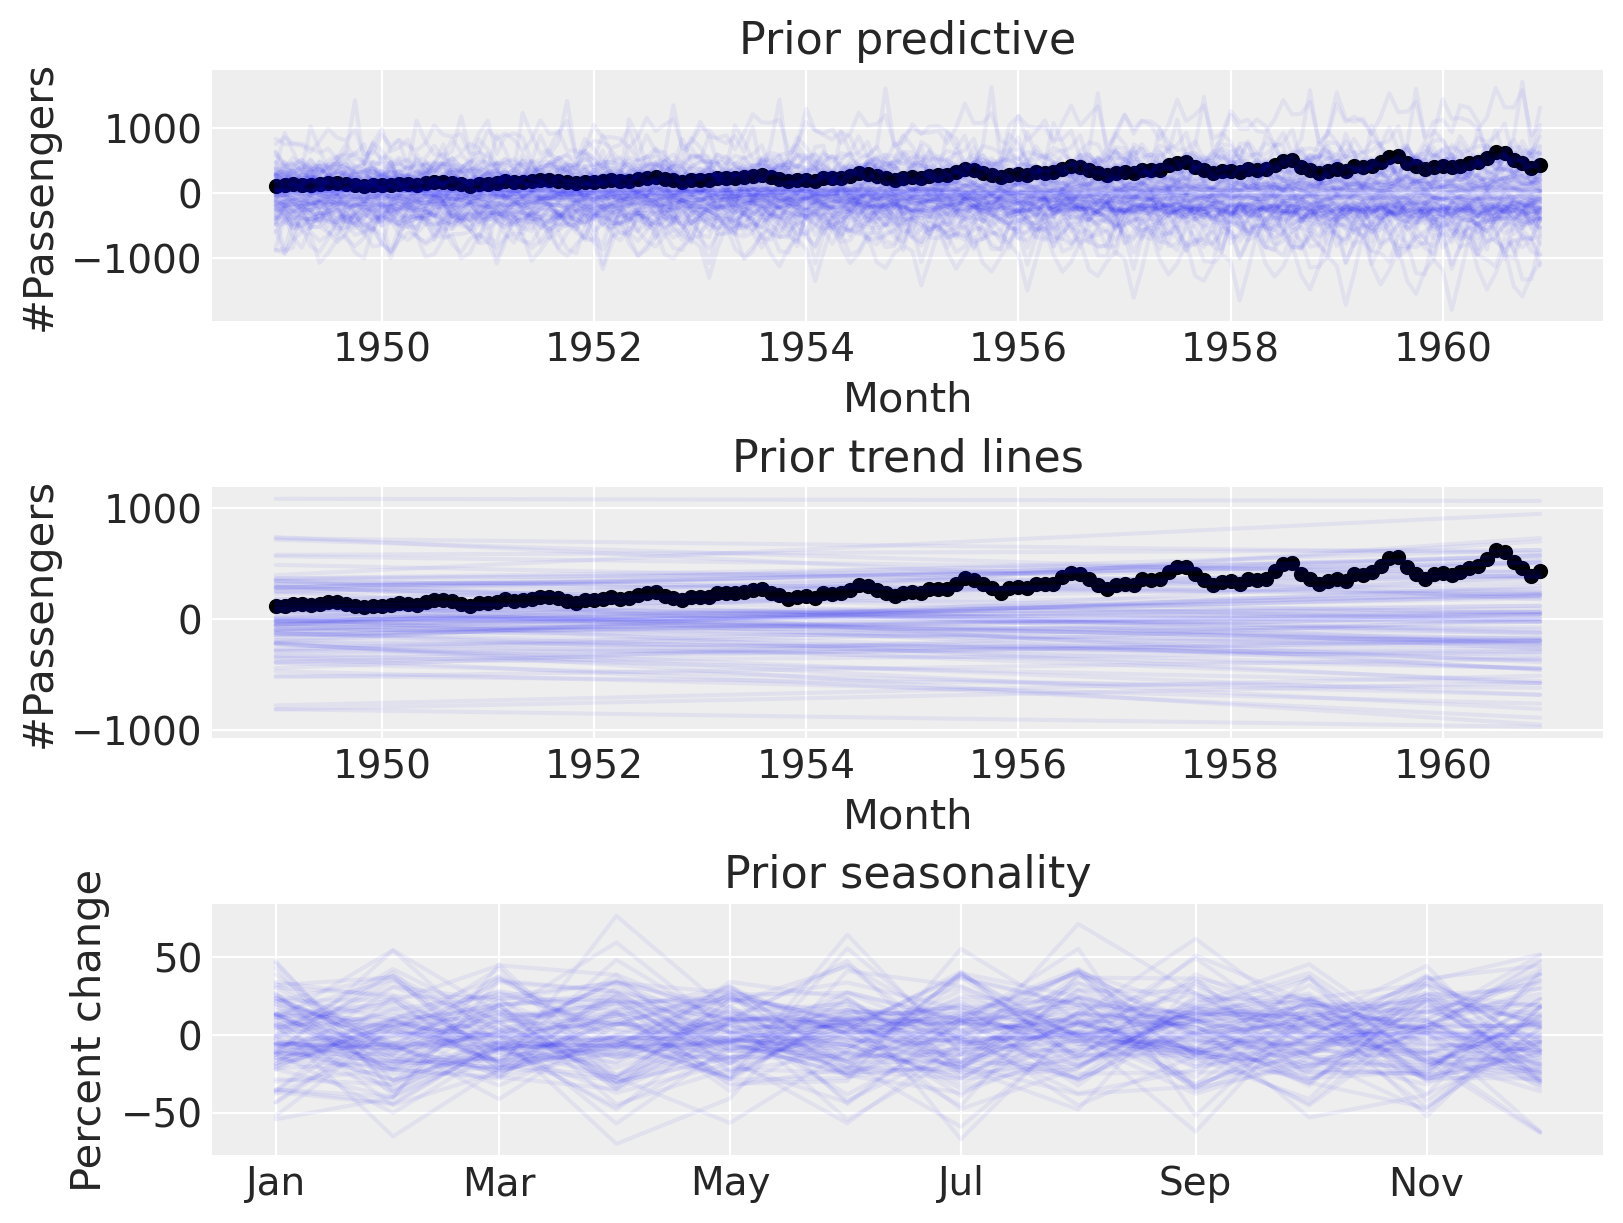

In [25]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", α + β * t)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=0.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )

    μ = trend * (1 + seasonality)
    σ = pm.HalfNormal("σ", sigma=0.1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_seasonality_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_seasonality_prior, group="prior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    az.extract_dataset(linear_seasonality_prior, group="prior", num_samples=100)["seasonality"][:12]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, β_fourier, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [likelihood]


Output()

/tmp/ipykernel_31239/2305994865.py:8: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
/tmp/ipykernel_31239/2305994865.py:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_31239/2305994865.py:27: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["seasonality"][


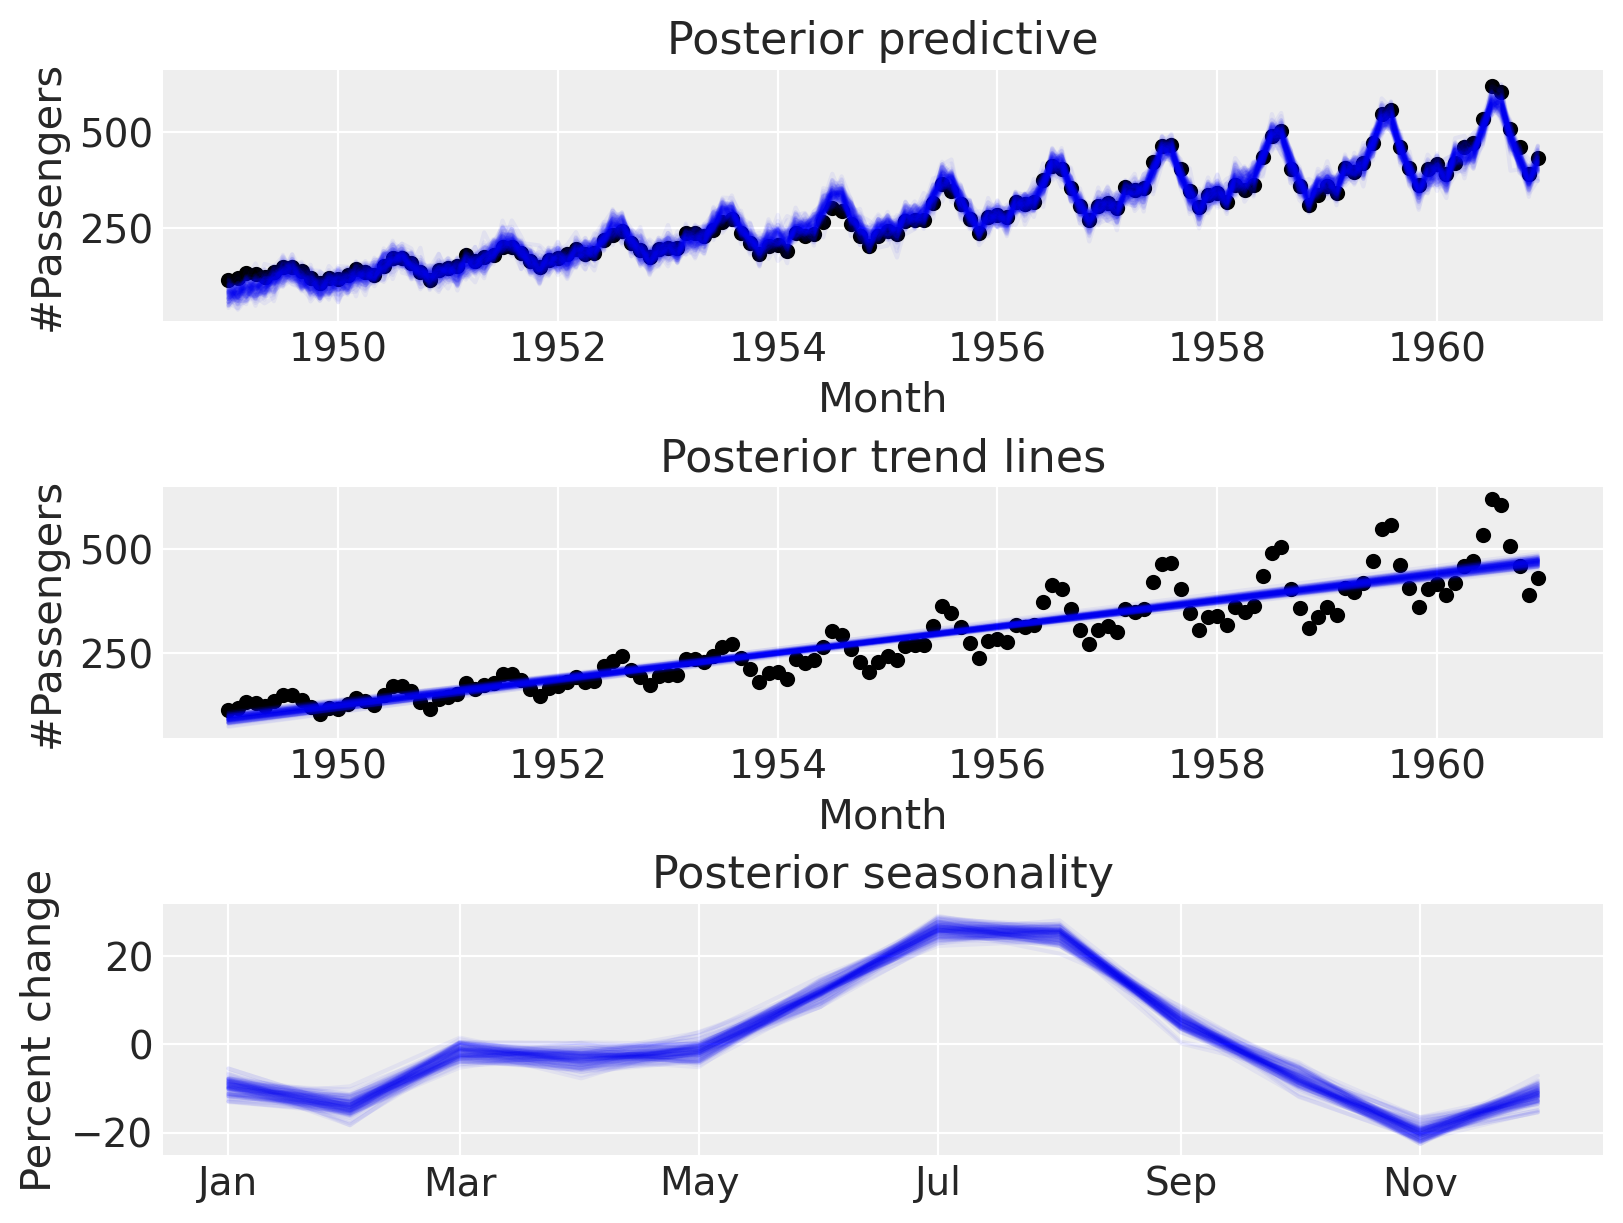

In [26]:
with linear_with_seasonality:
    linear_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_seasonality_posterior = pm.sample_posterior_predictive(trace=linear_seasonality_trace)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
        "likelihood"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["seasonality"][
        :12
    ]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);